<a href="https://colab.research.google.com/github/cffan/interspeech_iBCI_tutorial/blob/main/brain2text_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interspeech 24: Intracortical BCI Brain2Text Decoding Tutorial

**Aims**
1. Explore the Brain2Text dataset.
2. Build a Brain2Text iBCI decoder from scratch.
3. Use an n-gram language model to convert phoneme probabilities into words.

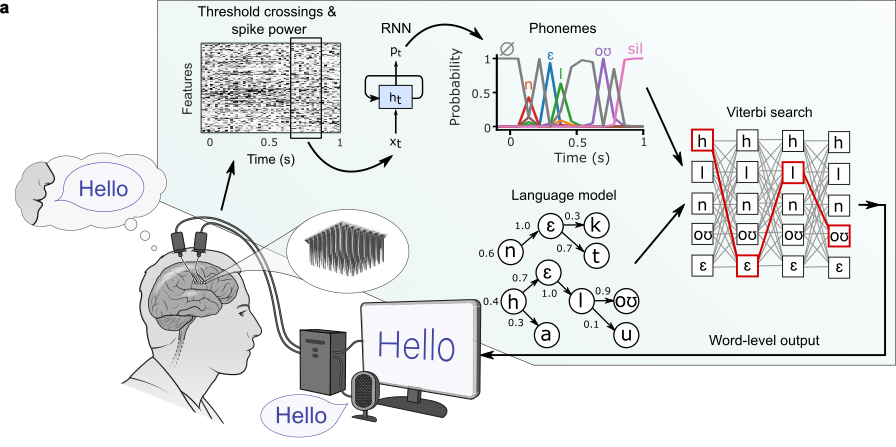

## Install dependencies

In [ ]:
!pip uninstall -y torch torchvision torchaudio fastai torchtext edit_distance
!pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu117
!pip install edit_distance crcmod

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 93.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for crcmod: filename=crcmod-1.7-cp310-cp310-linux_x86_64.whl size=31403 sha256=7a06e5a76da4626f1be5a7392847236d5793d2083c0519735d0ed86620d4e9fa
  Stored in directory: /root/.cache/pip/wheels/85/4c/07/72215c529bd59d67e3dac29711d7aba1b692f543c808ba9e86
Successfully built crcmod


## Explore the brain2text dataset

In [ ]:
!gsutil cp gs://cfan/interspeech24/brain2text_competition_data.pkl /content/

Copying gs://cfan/interspeech24/brain2text_competition_data.pkl...
\ [1 files][  3.3 GiB/  3.3 GiB]   72.8 MiB/s                                   
Operation completed over 1 objects/3.3 GiB.                                      


In [ ]:
import pickle

with open('/content/brain2text_competition_data.pkl', 'rb') as f:
  data = pickle.load(f)

print(f'Data partitions: {list(data.keys())}')

for part, part_data in data.items():
  print(f'  {part} partition: {len(part_data)} sessions')
  for day, day_data in enumerate(part_data):
    print(f'    session {day}: {len(day_data["sentenceDat"])} trials')
  print()

print(f'Structure of each trial: {list(data["train"][0].keys())}')

Data partitions: ['train', 'test', 'competition']
  train partition: 24 sessions
    session 0: 280 trials
    session 1: 360 trials
    session 2: 420 trials
    session 3: 180 trials
    session 4: 360 trials
    session 5: 360 trials
    session 6: 400 trials
    session 7: 360 trials
    session 8: 320 trials
    session 9: 320 trials
    session 10: 320 trials
    session 11: 480 trials
    session 12: 360 trials
    session 13: 360 trials
    session 14: 400 trials
    session 15: 400 trials
    session 16: 400 trials
    session 17: 200 trials
    session 18: 400 trials
    session 19: 320 trials
    session 20: 320 trials
    session 21: 440 trials
    session 22: 520 trials
    session 23: 520 trials

  test partition: 24 sessions
    session 0: 20 trials
    session 1: 20 trials
    session 2: 20 trials
    session 3: 20 trials
    session 4: 40 trials
    session 5: 40 trials
    session 6: 40 trials
    session 7: 40 trials
    session 8: 40 trials
    session 9: 40 trials


Shape of neural features: (591, 256)
Sentence: The eastern coast is a place for pure pleasure and excitement.
Phonemes: ['DH', 'AH', 'SIL', 'IY', 'S', 'T', 'ER', 'N', 'SIL', 'K', 'OW', 'S', 'T', 'SIL', 'IH', 'Z', 'SIL', 'AH', 'SIL', 'P', 'L', 'EY', 'S', 'SIL', 'F', 'AO', 'R', 'SIL', 'P', 'Y', 'UH', 'R', 'SIL', 'P', 'L', 'EH', 'ZH', 'ER', 'SIL', 'AH', 'N', 'D', 'SIL', 'IH', 'K', 'S', 'AY', 'T', 'M', 'AH', 'N', 'T', 'SIL']


<ipython-input-2-b08ec88b6ae0>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(time_axis * 0.02)


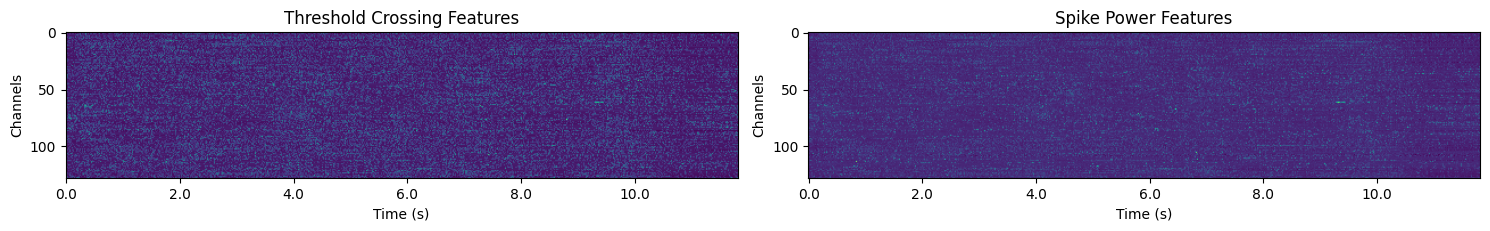

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define 39 phonemes + silence
PHONE_DEF = [
    'AA', 'AE', 'AH', 'AO', 'AW',
    'AY', 'B',  'CH', 'D', 'DH',
    'EH', 'ER', 'EY', 'F', 'G',
    'HH', 'IH', 'IY', 'JH', 'K',
    'L', 'M', 'N', 'NG', 'OW',
    'OY', 'P', 'R', 'S', 'SH',
    'T', 'TH', 'UH', 'UW', 'V',
    'W', 'Y', 'Z', 'ZH', 'SIL'
]

# Print a trial's info
day_idx = 0
trial_idx = 10
neural_feats = data['train'][day_idx]['sentenceDat'][trial_idx]
transcription = data['train'][day_idx]['transcriptions'][trial_idx]
n_phones = data['train'][day_idx]['phoneLens'][trial_idx]
phonemes = [PHONE_DEF[p - 1] for p in data['train'][day_idx]['phonemes'][trial_idx][:n_phones]]
print(f'Shape of neural features: {neural_feats.shape}')
print(f'Sentence: {transcription}')
print(f'Phonemes: {phonemes}')

# Plot the neural features
fig, axs = plt.subplots(1, 2, figsize=(15,8))
time_axis = np.arange(0, neural_feats.shape[0], 100)
axs[0].imshow(neural_feats[:, :128].T)  # The first 128 channels correspond to threshold crossing features
axs[1].imshow(neural_feats[:, 128:].T)  # The last 128 channels correspond to spike power features
axs[0].set_xticks(time_axis)
axs[0].set_xticklabels(time_axis * 0.02)  # 20ms time bin
axs[1].set_xticklabels(time_axis * 0.02)
axs[1].set_xticks(time_axis)
axs[0].set_xlabel('Time (s)')
axs[1].set_xlabel('Time (s)')
axs[0].set_ylabel('Channels')
axs[1].set_ylabel('Channels')
axs[0].set_title('Threshold Crossing Features')
axs[1].set_title('Spike Power Features')
plt.tight_layout()
plt.show()


### Exercise 1

Plot the neural features for a single channel. What do you discover?

In [ ]:
# Your answer here

## Build brain2text model

### Dataset class

In [ ]:
import torch
from torch.utils.data import Dataset


class SpeechDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.n_days = len(data)
        self.n_trials = sum([len(d["sentenceDat"]) for d in data])

        self.neural_feats = []
        self.phone_seqs = []
        self.neural_time_bins = []
        self.phone_seq_lens = []
        self.days = []
        for day in range(self.n_days):
            for trial in range(len(data[day]["sentenceDat"])):
                self.neural_feats.append(data[day]["sentenceDat"][trial])
                self.phone_seqs.append(data[day]["phonemes"][trial])
                self.neural_time_bins.append(data[day]["sentenceDat"][trial].shape[0])
                self.phone_seq_lens.append(data[day]["phoneLens"][trial])
                self.days.append(day)

    def __len__(self):
        return self.n_trials

    def __getitem__(self, idx):
        return (
            torch.tensor(self.neural_feats[idx], dtype=torch.float32),
            torch.tensor(self.phone_seqs[idx], dtype=torch.int32),
            torch.tensor(self.neural_time_bins[idx], dtype=torch.int32),
            torch.tensor(self.phone_seq_lens[idx], dtype=torch.int32),
            torch.tensor(self.days[idx], dtype=torch.int64),
        )

### Model classes

In [ ]:
import math
import numbers

from torch import nn
from torch.nn import functional as F



class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """

    def __init__(self, channels, kernel_size, sigma, dim=2):
        super(GaussianSmoothing, self).__init__()
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [torch.arange(size, dtype=torch.float32) for size in kernel_size]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= (
                1
                / (std * math.sqrt(2 * math.pi))
                * torch.exp(-(((mgrid - mean) / std) ** 2) / 2)
            )

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

        self.register_buffer("weight", kernel)
        self.groups = channels

        if dim == 1:
            self.conv = F.conv1d
        elif dim == 2:
            self.conv = F.conv2d
        elif dim == 3:
            self.conv = F.conv3d
        else:
            raise RuntimeError(
                "Only 1, 2 and 3 dimensions are supported. Received {}.".format(dim)
            )

    def forward(self, input):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        return self.conv(input, weight=self.weight, groups=self.groups, padding="same")


class GRUDecoder(nn.Module):
    """
    GRU Decoder

    Arguments:
      neural_dim (int): Number of channels in the input neural features.
      n_classes (int): Number of classes in the output sequence.
      hidden_dim (int): Number of hidden units in the GRU layer.
      layer_dim (int): Number of layers in the GRU layer.
      n_days (int): Number of day-specific transform layer.
      dropout (float): GRU dropout rate.
      stride (int): Stride of sliding window for feature stacking.
      kernel (int): Kernel size of sliding window for feature stacking.
      gaussian_smooth_sigma (float): Standard deviation of gaussian smoothing.
      gaussian_smooth_kernel (int): Kernel size of gaussian smoothing.
      bidirectional (bool): Whether to use bidirectional GRU layer.
    """
    def __init__(
        self,
        neural_dim,
        n_classes,
        hidden_dim,
        n_layers,
        n_days,
        dropout=0,
        stride=4,
        kernel=14,
        gaussian_smooth_sigma=2,
        gaussian_smooth_kernel=20,
        bidirectional=False,
    ):
        super(GRUDecoder, self).__init__()

        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.neural_dim = neural_dim
        self.n_classes = n_classes
        self.n_days = n_days
        self.dropout = dropout
        self.stride = stride
        self.kernel = kernel
        self.bidirectional = bidirectional
        self.gru_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.input_layer_nonlinearity = torch.nn.Softsign()
        self.unfolder = torch.nn.Unfold((self.kernel, 1), dilation=1, padding=0, stride=self.stride)
        self.gaussian_smooth = GaussianSmoothing(neural_dim, gaussian_smooth_kernel, gaussian_smooth_sigma, dim=1)

        # Parameters for day-specific layers
        self.day_weights = torch.nn.Parameter(torch.randn(n_days, neural_dim, neural_dim))
        self.day_bias = torch.nn.Parameter(torch.zeros(n_days, 1, neural_dim))

        for x in range(n_days):
            self.day_weights.data[x, :, :] = torch.eye(neural_dim)  # Initialize day-specific transforms with identity matrix

        # GRU layers
        self.gru_decoder = nn.GRU(
            neural_dim * self.kernel,  # Stacked inputs
            hidden_dim,
            n_layers,
            batch_first=True,
            dropout=self.dropout,
            bidirectional=self.bidirectional,
        )

        # Linear output layer
        self.fc_decoder_out = nn.Linear(self.gru_output_dim, n_classes + 1)  # +1 for CTC blank

    def forward(self, neural_feats, neural_feats_lens, day_idx):
        """
        Arguments:
          neural_feats (torch.Tensor): Input neural features. Shape: (batch, time, channels).
          day_idx (torch.Tensor): Day index.
        """

        # Gaussian smoothing
        neural_feats = torch.permute(neural_feats, (0, 2, 1))
        neural_feats = self.gaussian_smooth(neural_feats)
        neural_feats = torch.permute(neural_feats, (0, 2, 1))

        # Apply day-specific transform
        day_weights = torch.index_select(self.day_weights, 0, day_idx)
        neural_feats = torch.einsum("btd,bdk->btk", neural_feats, day_weights) + \
            torch.index_select(self.day_bias, 0, day_idx)
        neural_feats = self.input_layer_nonlinearity(neural_feats)

        # Stacking features with a sliding window
        stacked_neural_feats = torch.permute(
            self.unfolder(torch.unsqueeze(torch.permute(neural_feats, (0, 2, 1)), 3)),
            (0, 2, 1),
        )

        # GRU
        batch_size = stacked_neural_feats.size(0)
        h0 = torch.zeros(
            self.n_layers * 2 if self.bidirectional else self.n_layers,
            batch_size,
            self.hidden_dim,
            device=neural_feats.device,
        )
        h, _ = self.gru_decoder(stacked_neural_feats, h0)

        # Linear output layer
        output = self.fc_decoder_out(h)
        output_lens = ((neural_feats_lens - self.kernel) / self.stride + 1).to(torch.int32)
        return output, output_lens

### Training loop

In [ ]:
import os
import pickle
import time

from edit_distance import SequenceMatcher
import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader


def get_dataset_loaders(
    data_path,
    batch_size,
    day_indices=None,
):
    with open(data_path, "rb") as handle:
        loaded_data = pickle.load(handle)

    # Pad neural features and phoneme labels
    def _padding(batch):
        X, y, X_lens, y_lens, days = zip(*batch)
        X_padded = pad_sequence(X, batch_first=True, padding_value=0)
        y_padded = pad_sequence(y, batch_first=True, padding_value=0)

        return (
            X_padded,
            y_padded,
            torch.stack(X_lens),
            torch.stack(y_lens),
            torch.stack(days),
        )

    # Load data according to the day indices
    if day_indices is None:
        day_indices = list(range(len(loaded_data["train"])))
    train_ds = SpeechDataset([loaded_data["train"][d] for d in day_indices])
    test_ds = SpeechDataset([loaded_data["test"][d] for d in day_indices])

    # Set up dataloaders
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
        collate_fn=_padding,
    )
    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
        collate_fn=_padding,
    )

    return train_loader, test_loader, loaded_data

def eval_model(model, test_loader, device, loss_func=None, test_day_idx=None):

  with torch.no_grad():
    model.eval()

    test_losses = []
    decoded_seqs = []
    true_seqs = []
    total_edit_distance = 0
    total_seq_length = 0
    for X, y, X_lens, y_lens, day_idx in test_loader:
        X, y, X_lens, y_lens, day_idx = (
            X.to(device),
            y.to(device),
            X_lens.to(device),
            y_lens.to(device),
            day_idx.to(device),
        )
        if test_day_idx is not None:
          day_idx = torch.tensor([test_day_idx] * X.shape[0]).to(device)

        pred, pred_lens = model.forward(X, X_lens, day_idx)
        if loss_func is not None:
          loss = loss_func(
              torch.permute(pred.log_softmax(2), [1, 0, 2]),
              y,
              pred_lens,
              y_lens,
          )
          loss = torch.sum(loss)
          test_losses.append(loss.cpu().detach().numpy())

        # Compute CER
        for j in range(pred.shape[0]):
            decoded_seq = torch.argmax(pred[j, 0:pred_lens[j], :], dim=-1)
            decoded_seq = torch.unique_consecutive(decoded_seq, dim=-1)
            decoded_seq = decoded_seq.cpu().detach().numpy()
            decoded_seq = np.array([i for i in decoded_seq if i != 0])

            true_seq = np.array(y[j][0:y_lens[j]].cpu().detach())

            matcher = SequenceMatcher(
                a=true_seq.tolist(), b=decoded_seq.tolist()
            )
            total_edit_distance += matcher.distance()
            total_seq_length += len(true_seq)
            decoded_seqs.append(decoded_seq)
            true_seqs.append(true_seq)

    cer = total_edit_distance / total_seq_length
    mean_loss = np.mean(test_losses) if len(test_losses) > 0 else 0
    return cer, decoded_seqs, true_seqs, mean_loss


def train_model(args):
    torch.manual_seed(args["seed"])
    np.random.seed(args["seed"])
    device = args["device"]

    if not os.path.exists(args["output_dir"]):
      os.makedirs(args["output_dir"])

    # Load data
    train_loader, test_loader, loaded_data = get_dataset_loaders(
        args["dataset_path"],
        args["batch_size"],
        args["day_indices"]
    )

    # Build model
    model = GRUDecoder(
        neural_dim=args["neural_feats_dim"],
        n_classes=args["phone_classes"],
        hidden_dim=args["gru_hidden_units"],
        n_layers=args["gru_layers"],
        n_days=len(args["day_indices"]),
        dropout=args["dropout"],
        stride=args["stride"],
        kernel=args["kernel"],
        gaussian_smooth_sigma=args["gaussian_smooth_sigma"],
        gaussian_smooth_kernel=args["gaussian_smooth_kernel"],
        bidirectional=args["bidirectional"],
    ).to(device)

    # Build loss and optimizer
    loss_ctc = torch.nn.CTCLoss(blank=0, reduction="mean", zero_infinity=True)
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=args["lr_start"],
        betas=(0.9, 0.999),
        eps=0.1,
        weight_decay=args["l2_decay"],
    )
    scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        start_factor=1.0,
        end_factor=args["lr_end"] / args["lr_start"],
        total_iters=args["train_batches"],
    )

    # Train
    train_loss = []
    test_loss = []
    test_cer = []
    for batch in range(args["train_batches"]):
        model.train()

        X, y, X_lens, y_lens, day_idx = next(iter(train_loader))
        X, y, X_lens, y_lens, day_idx = (
            X.to(device),
            y.to(device),
            X_lens.to(device),
            y_lens.to(device),
            day_idx.to(device),
        )

        # Noise augmentation is faster on GPU
        if args["white_noise_sd"] > 0:
            X += torch.randn(X.shape, device=device) * args["white_noise_sd"]
        if args["constant_offset_noise_sd"] > 0:
            X += (
                torch.randn([X.shape[0], 1, X.shape[2]], device=device)
                * args["constant_offset_noise_sd"]
            )

        # Forward pass
        pred, pred_lens = model.forward(X, X_lens, day_idx)
        loss = loss_ctc(
            torch.permute(pred.log_softmax(2), [1, 0, 2]),
            y,
            pred_lens,
            y_lens,
        )
        loss = torch.sum(loss)
        train_loss.append(loss.cpu().detach().numpy())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Eval
        if batch % 100 == 99:
            cer, _, _, test_loss = eval_model(model, test_loader, device, loss_func=loss_ctc)
            test_cer.append(cer)
            print(
                f"batch {batch}, train loss: {np.mean(train_loss):>4f}, test loss: {test_loss:>4f}, test cer: {cer:>4f}"
            )
            train_loss = []

            if len(test_cer) > 0 and cer <= np.min(test_cer):
                torch.save(model.state_dict(), f"{args['output_dir']}/model.pt")



### Train a toy model

In [ ]:
args = {}
args['dataset_path'] = '/content/brain2text_competition_data.pkl'
args['output_dir'] = '/content/brain2text_toy_model/'
args['day_indices'] = [0, 1, 2, 3]
args['batch_size'] = 64
args['lr_start'] = 0.02
args['lr_end'] = 0.02
args['gru_hidden_units'] = 128
args['train_batches'] = 5000
args['gru_layers'] = 2
args['seed'] = 0
args['phone_classes'] = 40
args['neural_feats_dim'] = 256
args['dropout'] = 0.4
args['white_noise_sd'] = 0.8
args['constant_offset_noise_sd'] = 0.2
args['gaussian_smooth_sigma'] = 2.0
args['gaussian_smooth_kernel'] = 20
args['stride'] = 4
args['kernel'] = 5
args['bidirectional'] = False
args['l2_decay'] = 1e-5
args['device'] = 'cuda'

train_model(args)

#### Exercise 2

Download models trained on 1 day, 4 days, 8 days, and 24 days of data. Plot the phoneme error rate (PER) of each model. How does the PER change as the number of training days increase?

In [ ]:
# Download all models
!gsutil cp -r gs://cfan/interspeech24/brain2text_model_1-day /content/
!gsutil cp -r gs://cfan/interspeech24/brain2text_model_4-day /content/
!gsutil cp -r gs://cfan/interspeech24/brain2text_model_8-day /content/
!gsutil cp -r gs://cfan/interspeech24/brain2text_model_24-day /content/


Copying gs://cfan/interspeech24/brain2text_model_1-day/model.pt...
/ [1 files][  2.7 MiB/  2.7 MiB]                                                
Operation completed over 1 objects/2.7 MiB.                                      
Copying gs://cfan/interspeech24/brain2text_model_4-day/model.pt...
/ [1 files][  3.5 MiB/  3.5 MiB]                                                
Operation completed over 1 objects/3.5 MiB.                                      
Copying gs://cfan/interspeech24/brain2text_model_8-day/model.pt...
/ [1 files][  4.5 MiB/  4.5 MiB]                                                
Operation completed over 1 objects/4.5 MiB.                                      
Copying gs://cfan/interspeech24/brain2text_model_24-day/model.pt...
/ [1 files][  8.5 MiB/  8.5 MiB]                                                
Operation completed over 1 objects/8.5 MiB.                                      


In [ ]:
# Load the 1-day model and evaluate its PER
model_path = "/content/brain2text_model_1-day/model.pt"

# Data loaders for 1-day model
day_indices = list(range(1))
_, test_loader, _ = get_dataset_loaders(
    args["dataset_path"],
    args["batch_size"],
    day_indices
)

model_1day = GRUDecoder(
    neural_dim=args["neural_feats_dim"],
    n_classes=args["phone_classes"],
    hidden_dim=args["gru_hidden_units"],
    n_layers=args["gru_layers"],
    n_days=len(day_indices),
    dropout=args["dropout"],
    stride=args["stride"],
    kernel=args["kernel"],
    gaussian_smooth_sigma=args["gaussian_smooth_sigma"],
    gaussian_smooth_kernel=args["gaussian_smooth_kernel"],
    bidirectional=args["bidirectional"],
).to(args["device"])

model_1day.load_state_dict(torch.load(model_path, map_location=args["device"]))

per_1day, decoded_seqs, true_seqs, _ = eval_model(model_1day, test_loader, args["device"], loss_func=None)
print(f'1-day model PER: {per_1day:.2f}')

print()
print('Examples of decoded phoneme sequences')
for decoded_seq, true_seq in zip(decoded_seqs, true_seqs):
  print('HYP: ' + ' '.join([PHONE_DEF[p - 1] for p in decoded_seq]))
  print('REF: ' + ' '.join([PHONE_DEF[p - 1] for p in true_seq]))
  print()
  break

1-day model PER: 0.47

Examples of decoded phoneme sequences
HYP: DH IH S SIL K IH S SIL R IH K AE N AH D SIL
REF: TH IY AA K R AH S IY SIL R IY K AH N S IH D ER D SIL



In [ ]:
# Your answer here

# Load the 4-day, 8-day, 24-day models and plot their PER against number of training days

#### Exercise 3

Let's take a look at neural non-stationarity. Intracortical neural recordings change all the time. Let's take the 4-day model (trained on day 0, 1, 2, 3) and plot its PER on future days (day 4 - 23). What does the trend tell you about the non-staionarity?



In [ ]:
# Load the 4-day model
model_path = "/content/brain2text_model_4-day/model.pt"
model_4day = GRUDecoder(
    neural_dim=args["neural_feats_dim"],
    n_classes=args["phone_classes"],
    hidden_dim=args["gru_hidden_units"],
    n_layers=args["gru_layers"],
    n_days=4,
    dropout=args["dropout"],
    stride=args["stride"],
    kernel=args["kernel"],
    gaussian_smooth_sigma=args["gaussian_smooth_sigma"],
    gaussian_smooth_kernel=args["gaussian_smooth_kernel"],
    bidirectional=args["bidirectional"],
).to(args["device"])

model_4day.load_state_dict(torch.load(model_path, map_location=args["device"]))

<All keys matched successfully>

In [ ]:
# Data loader for day 3
_, test_loader, _ = get_dataset_loaders(
    args["dataset_path"],
    args["batch_size"],
    day_indices=[3]
)

# Evaluate the model on day 3's data and day 3's transform
per, _, _, _ = eval_model(model_4day, test_loader, args["device"], test_day_idx=3)
print(per)


0.4080717488789238


In [ ]:
# Evaluate PER on day 4 - 23. Plot the PER for each day.



## Phonemes to words decoding with n-gram language model

### Install the n-gram LM decoder

In [ ]:
# Install LM Decoder (based on Kaldi and WeNet)
%cd /content
!git clone https://github.com/fwillett/speechBCI.git
%cd speechBCI
!git checkout interspeech
!cd LanguageModelDecoder/runtime/server/x86/ && CMAKE_BUILD_PARALLEL_LEVEL=4 pip install .

/content
Cloning into 'speechBCI'...
remote: Enumerating objects: 3036, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 3036 (delta 75), reused 156 (delta 70), pack-reused 2868 (from 1)
Receiving objects: 100% (3036/3036), 78.36 MiB | 48.84 MiB/s, done.
Resolving deltas: 100% (410/410), done.
/content/speechBCI
Branch 'interspeech' set up to track remote branch 'interspeech' from 'origin'.
Switched to a new branch 'interspeech'
Processing /content/speechBCI/LanguageModelDecoder/runtime/server/x86
  Preparing metadata (setup.py) ... done
  Created wheel for lm_decoder: filename=lm_decoder-0.0.1-cp310-cp310-linux_x86_64.whl size=660177 sha256=055a518737b09f6be4932ff7e7a4ca442ed300ba0c8c093dd65b1ef25ce1a8e5
  Stored in directory: /tmp/pip-ephem-wheel-cache-pmm9zvti/wheels/8f/c5/7f/3629b0f29c8d6841e4805863da61401a872f30d99d575f865d
Successfully built lm_decoder


In [ ]:
# Download the 3-gram LM (trained on OpenWebText2)
%cd /content/
!gsutil -m cp gs://cfan/interspeech24/3gram.tar.gz ./
!tar -zxvf 3gram.tar.gz

/content
Copying gs://cfan/interspeech24/3gram.tar.gz...
Resuming download for ./3gram.tar.gz component 0
Resuming download for ./3gram.tar.gz component 2
Resuming download for ./3gram.tar.gz component 3
Resuming download for ./3gram.tar.gz component 1
/ [1/1 files][  4.2 GiB/  4.2 GiB] 100% Done  69.1 MiB/s ETA 00:00:00           
Operation completed over 1 objects/4.2 GiB.                                      
speech_3gram/
speech_3gram/TLG.fst
speech_3gram/words.txt


### Load a pretrained GRU decoder

In [ ]:
# Download pretrained GRU decoder
%cd /content
!gsutil cp -r gs://cfan/interspeech24/brain2text_model_full/ /content

/content
Copying gs://cfan/interspeech24/brain2text_model_full/model.pt...
/ [1 files][402.6 MiB/402.6 MiB]                                                
Operation completed over 1 objects/402.6 MiB.                                    


In [ ]:
# Load the model
args = {}
args['dataset_path'] = '/content/brain2text_competition_data.pkl'
args['output_dir'] = '/content/brain2text_model_full/'
args['day_indices'] = list(range(24))
args['batch_size'] = 64
args['lr_start'] = 0.02
args['lr_end'] = 0.02
args['gru_hidden_units'] = 1024
args['train_batches'] = 10000
args['gru_layers'] = 5
args['seed'] = 0
args['phone_classes'] = 40
args['neural_feats_dim'] = 256
args['dropout'] = 0.4
args['white_noise_sd'] = 0.8
args['constant_offset_noise_sd'] = 0.2
args['gaussian_smooth_sigma'] = 2.0
args['gaussian_smooth_kernel'] = 20
args['stride'] = 4
args['kernel'] = 14
args['bidirectional'] = True
args['l2_decay'] = 1e-5
args['device'] = 'cuda'


train_loader, test_loader, loaded_data = get_dataset_loaders(
    args["dataset_path"],
    args["batch_size"],
    args["day_indices"]
)

model = GRUDecoder(
    neural_dim=args["neural_feats_dim"],
    n_classes=args["phone_classes"],
    hidden_dim=args["gru_hidden_units"],
    n_layers=args["gru_layers"],
    n_days=len(loaded_data["train"]),
    dropout=args["dropout"],
    stride=args["stride"],
    kernel=args["kernel"],
    gaussian_smooth_sigma=args["gaussian_smooth_sigma"],
    gaussian_smooth_kernel=args["gaussian_smooth_kernel"],
    bidirectional=args["bidirectional"],
).to(args["device"])

model.load_state_dict(torch.load(f"{args['output_dir']}/model.pt", map_location=args["device"]))

<All keys matched successfully>

In [ ]:
# Evaluate the model
per, decoded_seqs, true_seqs, _ = eval_model(model, test_loader, args["device"], loss_func=None)
print(f'PER: {per:.2f}')

PER: 0.20


### Phonemes to words decoding

In [ ]:
# Load LM
import lm_decoder

lm_dir = "/content/speech_3gram"

# Beam search parameters (See Kaldi's documentation)
decode_opts = lm_decoder.DecodeOptions(
    7000,  # max active,
    200,   # min active,
    17,    # beam,
    8,     # lattice_beam,
    0.5,   # acoustic_scale,
    1.0,   # ctc_blank_skip_threshold,
    0.0,   # length_penalty,
    100,   # nbest
)

decode_resource = lm_decoder.DecodeResource(
    f"{lm_dir}/TLG.fst",
    "",  # G.fst path
    "",   # rescore_G.fst path
    f"{lm_dir}/words.txt",
    ""
)
ngram_decoder = lm_decoder.BrainSpeechDecoder(decode_resource, decode_opts)


In [ ]:
# Get the logits (phoneme probabilities) from the GRU decoder

import re

rnn_outputs = {
    "logits": [],
    "logitLengths": [],
    "trueSeqs": [],
    "transcriptions": [],
}

device = args["device"]
with torch.no_grad():
  model.eval()

  for test_day_idx in range(len(loaded_data["test"])):
    # Construct a test loader
    test_ds = SpeechDataset([loaded_data["test"][test_day_idx]])
    test_loader = torch.utils.data.DataLoader(
        test_ds, batch_size=1, shuffle=False, num_workers=0
    )

    # Evaluate the model
    for j, (X, y, X_lens, y_lens, _) in enumerate(test_loader):
      X, y, X_lens, y_lens, days = (
          X.to(device),
          y.to(device),
          X_lens.to(device),
          y_lens.to(device),
          torch.tensor([test_day_idx], dtype=torch.int64).to(device),
      )

      # Get the logits and logit lengths for the LM decoder
      logits, logit_lens = model.forward(X, X_lens, days)
      rnn_outputs["logits"].append(logits[0].cpu().detach().numpy())
      rnn_outputs["logitLengths"].append(logit_lens[0].cpu().detach().item())

      # Get the ground truth phoneme sequence to compute PER
      true_seq = np.array(y[0][0:y_lens[0]].cpu().detach())
      rnn_outputs["trueSeqs"].append(true_seq)

      # Get the transcription to compute WER
      transcript = loaded_data["test"][test_day_idx]["transcriptions"][j].strip()
      transcript = re.sub(r"[^a-zA-Z\- \']", "", transcript)  # Remove non-alphabetic characters
      transcript = transcript.replace("--", "").lower()
      rnn_outputs["transcriptions"].append(transcript)

In [ ]:
# Decode phoneme probabilities to words

decoded_sentences = []
transcriptions = rnn_outputs['transcriptions']
blank_penalty = np.log(7)  # CTC blank penalty

for l in range(len(rnn_outputs['logits'])):
    logits = rnn_outputs['logits'][l]
    # Reshape logits to kaldi order: CTC_BLANK, SIL, PHONEMES
    logits = np.concatenate([logits[:, 0:1], logits[:, -1:], logits[:, 1:-1]], axis=-1)
    logit_len = rnn_outputs['logitLengths'][l]
    log_prior = np.zeros([1, logits.shape[1]])  # No prior on phonemes

    ngram_decoder.Reset()
    lm_decoder.DecodeNumpy(ngram_decoder, logits[:logit_len], log_prior, blank_penalty)
    ngram_decoder.FinishDecoding()

    if len(ngram_decoder.result()) == 0:
      decoded = ''
    else:
      decoded = ngram_decoder.result()[0].sentence

    decoded_sentences.append(decoded.strip())

In [ ]:
# Compute WER

from edit_distance import SequenceMatcher

total_words = 0
total_distance = 0
for decoded, transcript in zip(decoded_sentences, rnn_outputs['transcriptions']):
  print(f'REF: {transcript}')
  print(f'HYP: {decoded}')
  print()

  decoded = decoded.split(" ")
  transcript = transcript.split(" ")

  total_words += len(transcript)
  matcher = SequenceMatcher(decoded, transcript)
  total_distance += matcher.distance()

print(f'WER: {total_distance / total_words:.2f}')

REF: theocracy reconsidered
HYP: this weekend

REF: rich purchased several signed lithographs
HYP: last post ever signed lithograph

REF: so rules we made in unabashed collusion
HYP: the rules we met in and of collusion

REF: lori's costume needed black gloves to be completely elegant
HYP: cruz came did make love to be completely alien

REF: the tooth fairy forgot to come when roger's tooth fell out
HYP: the tooth fairy weak to come when workers to fill out

REF: that stinging vapor was caused by chloride vaporization
HYP: that thing if i was called the wide separation

REF: before thursday's exam review every formula
HYP: before thursday's game was ever formally

REF: wildfire near sunshine forces park closures
HYP: while new zealand first party

REF: the word means it won't boil away easily nothing else
HYP: the word means it won't boil away usually nothing else

REF: would a blue feather in a man's hat make him happy all day
HYP: would a bull phase in a man's height make him about a